In [1]:
# Import modules
import torch
import e3nn
import numpy as np
import random
from datetime import datetime
from torch_geometric.datasets import MD17
from model import InteractionModel
from dataloader import InteractionDataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

/home/sanghyeonl/miniforge3/envs/torch/lib/python3.9/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [2]:
import warnings

warnings.filterwarnings(
    "ignore",
    message="The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`.",
)

In [3]:
# Define constants
SEED = 42
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)
random.seed(SEED)

# Dataloader
TRAIN_SIZE = 25000  # NOTE
EVAL_SIZE = 1000
TEST_SIZE = 10000

# Model
# - Atomic
MAX_Z = 10
DIM_ATOMS = 30
IRREPS_ATOM = e3nn.o3.Irreps(f"{DIM_ATOMS}x0e")
# - Distance
# NOTE
MU_MIN = 0.0
MU_MAX = 10.0
STEP = 0.5
R_CUT = 10.0
DIM_R = int(np.ceil((MU_MAX - MU_MIN) / STEP) + 1)
IRREPS_R = e3nn.o3.Irreps(f"{DIM_R}x0e")
IRREPS_SH = e3nn.o3.Irreps.spherical_harmonics(2)
# - Readout
DIM_MID = 15
# - Layer
N_INTERACTIONS = 3

# Trainer
N_EPOCHS = 1000
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-3
EARLY_STOP_THRESHOLD = 10  # NOTE
MIN_EPOCHS = 5

DATASETS_PATH = "datasets"
CHECKPOINT_PATH = "MD17_malon_model.pt"
TARGET_MOLECULE = "revised malonaldehyde"

In [4]:
def loss_fn(predict, label):
    return (predict - label) ** 2

In [5]:
def random_rotation(device, data):
    random_mat = e3nn.o3.rand_matrix().to(device)
    data.update({"pos": data["pos"] @ random_mat.T})
    return data

In [6]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [7]:
# Initiate model
model = InteractionModel(
    device=device,
    activation_fn=torch.nn.SiLU(),
    r_cut=R_CUT,
    max_z=MAX_Z,
    dim_atoms=DIM_ATOMS,
    dim_mid=DIM_MID,
    mu_min=MU_MIN,
    mu_max=MU_MAX,
    step=STEP,
    irreps_r=IRREPS_R,
    irreps_sh=IRREPS_SH,
    irreps_atom=IRREPS_ATOM,
    n_interactions=N_INTERACTIONS,
    energy_conversion=lambda x: x,
)

optimizer = torch.optim.Adam(
    model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY
)
# TODO scheduler
scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer=optimizer, lr_lambda=lambda epoch: 0.95**epoch
)

In [8]:
mode = "single"
assert mode in ["single", "multiple"]

In [9]:
# Load datasets
if mode == "single":
    # TODO QM9
    raw_data = MD17(DATASETS_PATH, TARGET_MOLECULE).to(device)
    idx = random.sample(
        np.arange(len(raw_data)).tolist(), TRAIN_SIZE + EVAL_SIZE + TEST_SIZE
    )
    idx = np.split(
        idx, [TRAIN_SIZE, TRAIN_SIZE + EVAL_SIZE, TRAIN_SIZE + EVAL_SIZE + TEST_SIZE]
    )
    train_idx = idx[0]
    np.random.shuffle(train_idx)
    eval_idx = idx[1]
    test_idx = idx[2]
    train_dataset = InteractionDataLoader(raw_data[train_idx])
    eval_dataset = InteractionDataLoader(raw_data[eval_idx])
    test_dataset = InteractionDataLoader(raw_data[test_idx])
elif mode == "multiple":
    # TODO
    train_molecules = [
        "revised toluene",
        "revised salicylic acid",
        "revised paracetamol",
        "revised aspirin",
        "revised azobenzene",
        "revised benzene",
        "revised uracil",
        "revised naphthalene",
        "revised malonaldehyde",
        "revised ethanol",
    ]
    raw_datasets = [
        MD17(DATASETS_PATH, molecule).to(device)
        for molecule in train_molecules
        if molecule != TARGET_MOLECULE
    ]
    indices = [
        random.sample(np.arange(len(raw_dataset)).tolist(), TRAIN_SIZE + EVAL_SIZE)
        for raw_dataset in raw_datasets
    ]
    indices = [
        np.split(index, [TRAIN_SIZE, TRAIN_SIZE + EVAL_SIZE]) for index in indices
    ]
    train_dataset = [
        [
            {**data.to_dict(), "name": raw_datasets[i].name}
            for data in raw_datasets[i][index[0]]
        ]
        for (i, index) in enumerate(indices)
    ]
    train_dataset = [item for subset in train_dataset for item in subset]
    np.random.shuffle(train_dataset)
    eval_dataset = [
        [
            {**data.to_dict(), "name": raw_datasets[i].name}
            for data in raw_datasets[i][index[1]]
        ]
        for (i, index) in enumerate(indices)
    ]
    eval_dataset = [item for subset in eval_dataset for item in subset]

    test_molecule = TARGET_MOLECULE
    test_dataset = MD17(DATASETS_PATH, test_molecule).to(device)
    test_indices = random.sample(np.arange(len(test_dataset)).tolist(), TEST_SIZE)
    test_dataset = InteractionDataLoader(test_dataset[test_indices])

In [10]:
# Run train and evalutaion loop
train_loss = []
eval_loss = []
best_loss = torch.inf
best_plot = []

early_stop_counter = 0

for epoch in range(N_EPOCHS):
    model.train()
    train_loss.append([])
    plot = []
    for i, batch in enumerate(
        tqdm(train_dataset, desc=f"Epoch #{epoch + 1:02} (Train)")
    ):
        data, readout = model(batch)
        loss = loss_fn(data["e"], readout)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        plot.append((data["e"].item(), readout.item(), data["name"]))

        train_loss[-1].append(loss.item())
    scheduler.step()

    eval_loss.append([])
    model.eval()
    with torch.no_grad():
        for i, batch in enumerate(
            tqdm(eval_dataset, desc=f"Epoch #{epoch + 1:02} (Valid)")
        ):
            data, readout = model(batch)
            loss = loss_fn(data["e"], readout)
            eval_loss[-1].append(loss.item())

    if epoch > MIN_EPOCHS:
        if np.mean(eval_loss[-1]) < best_loss:
            best_loss = np.mean(eval_loss[-1])
            best_plot = plot
            torch.save(
                {
                    "epoch": epoch,
                    "model_state_dict": model.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict(),
                    "loss": best_loss,
                },
                CHECKPOINT_PATH,
            )
            early_stop_counter = 0
        else:
            early_stop_counter += 1

        if early_stop_counter > EARLY_STOP_THRESHOLD:
            break

Epoch #33 (Valid): 100%|██████████| 1000/1000 [00:02<00:00, 383.42it/s]


In [10]:
# Load checkpoint
checkpoint = torch.load(CHECKPOINT_PATH)
model.load_state_dict(checkpoint["model_state_dict"])
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
epoch = checkpoint["epoch"]
loss = checkpoint["loss"]

In [11]:
# Test model
test_plot = []
test_loss = []
model.eval()
with torch.no_grad():
    for i, batch in enumerate(tqdm(test_dataset)):
        data, readout = model(batch)
        test_plot.append([data["e"].item(), readout.item()])
        test_loss.append(loss_fn(data["e"].item(), readout.item()))

100%|██████████| 10000/10000 [00:26<00:00, 382.94it/s]


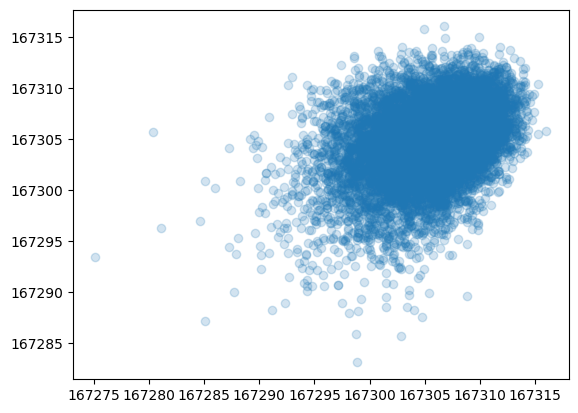

-0.15775622708830395

In [24]:
plt.scatter([x[0] for x in test_plot], [x[1] for x in test_plot], alpha=0.2)
# axis = np.arange(167280, 167320, 0.5)
# plt.plot(axis, axis)
plt.show()

r2_score([x[0] for x in test_plot], [x[1] for x in test_plot])

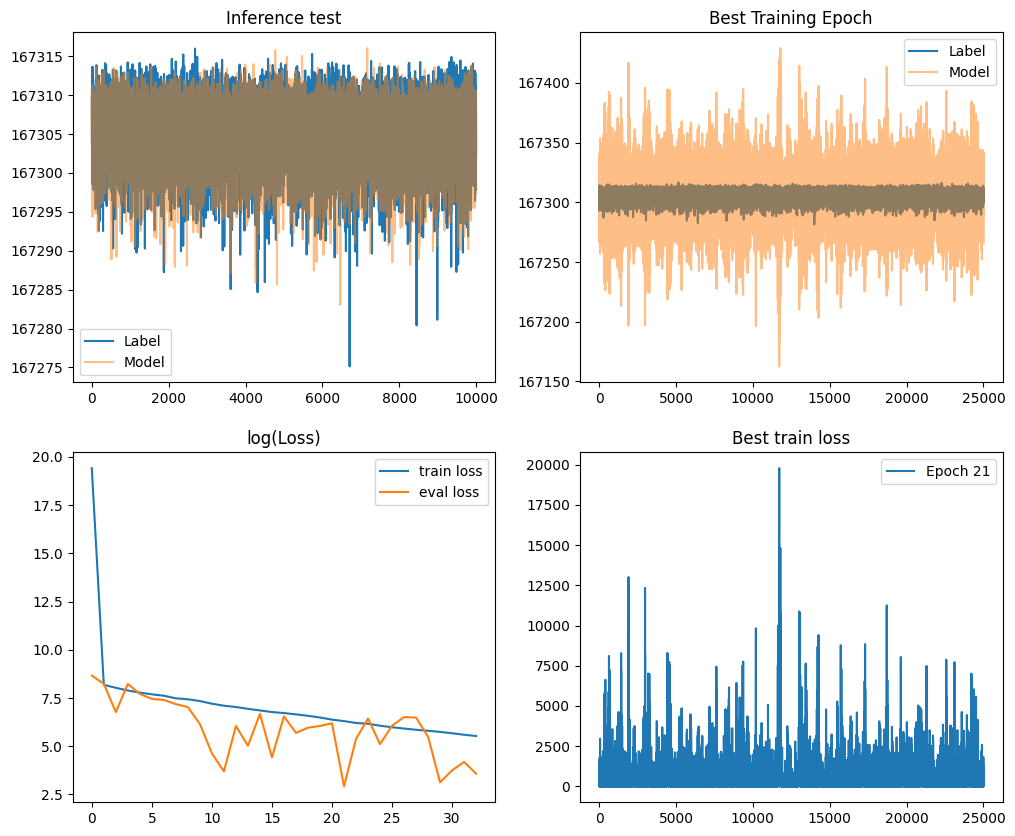

In [13]:
fig = plt.figure(figsize=(12, 10))
axes = fig.subplots(2, 2)


axes[0][0].plot([x[0] for x in test_plot], label="Label")
axes[0][0].plot([x[1] for x in test_plot], label="Model", alpha=0.5)
axes[0][0].legend()
axes[0][0].set_title("Inference test")

if mode == "single":
    axes[0][1].plot([x[0] for x in best_plot], label="Label")
    axes[0][1].plot([x[1] for x in best_plot], label="Model", alpha=0.5)
    axes[0][1].legend()
    axes[0][1].set_title("Best Training Epoch")
elif mode == "multiple":
    plot_dict = dict()
    for x in best_plot:
        if x[2] in plot_dict:
            plot_dict[x[2]].append((x[0], x[1]))
        else:
            plot_dict[x[2]] = [(x[0], x[1])]
    for k, v in plot_dict.items():
        axes[0][1].scatter(
            [x[0] for x in v],
            [x[1] for x in v],
            alpha=1.0,
            label=k.split("revised ")[-1],
        )
    axes[0][1].scatter(
        [x[0] for x in test_plot],
        [x[1] for x in test_plot],
        alpha=1.0,
        label=f"test, {test_molecule.split('revised ')[-1]}",
    )
    axes[0][1].legend()
    axes[0][1].set_title("Scatter Plot")

axes[1][0].plot([np.log(np.mean(loss)) for loss in train_loss], label="train loss")
axes[1][0].plot([np.log(np.mean(loss)) for loss in eval_loss], label="eval loss")
axes[1][0].legend()
axes[1][0].set_title("log(Loss)")

axes[1][1].plot(train_loss[epoch], label=f"Epoch {epoch:02}")
axes[1][1].legend()
axes[1][1].set_title("Best train loss")

fig.show()

In [14]:
print(f"Best train loss : {loss:.2e} (MSE, kcal/mol)")
print(f"Test loss       : {np.mean(test_loss):.2e} (MSE, kcal/mol)")
print()
print(f"Test Error      : {(np.mean(test_loss) ** 0.5):.2e} kcal/mol")

Best train loss : 1.85e+01 (MSE, kcal/mol)
Test loss       : 2.01e+01 (MSE, kcal/mol)

Test Error      : 4.49e+00 kcal/mol


In [15]:
print(
    f"Parameters in model : {sum([p.numel() for p in model.parameters() if p.requires_grad])}"
)

Parameters in model : 60211


In [16]:
r2_test = best_plot
print(f"Train R2 : {r2_score([x[0] for x in r2_test], [x[1] for x in r2_test])}")

Train R2 : -30.55820852069865


In [17]:
r2_test = test_plot
print(f"Test R2 : {r2_score([x[0] for x in r2_test], [x[1] for x in r2_test])}")

Test R2 : -0.15769818955172


In [18]:
name = "_".join(TARGET_MOLECULE.split())
rmse = torch.tensor(test_loss) ** 0.5
std, mean = torch.std_mean(rmse)

In [19]:
now = datetime.now()
date = f"{now.year}/{now.month:02}/{now.day:02}"
report = f"{name}({TRAIN_SIZE//1000}k) : {mean.item():.2f} ± {std.item():.2f} [kcal/mol]  {date}\n"
report_path = "MD17_report.txt"
with open(report_path, "a", encoding="UTF-8") as report_file:
    report_file.write(report)

In [20]:
report

'revised_malonaldehyde(25k) : 3.54 ± 2.75 [kcal/mol]  2024/08/01\n'